<a href="https://colab.research.google.com/github/thiagomotax/nlp-user-profiles/blob/master/deep_learning_nlp_my_personality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)


df = pd.read_csv('/content/drive/My Drive/tcc/datasets/mypersonality/mypersonality_final.csv', encoding="ISO-8859-1")
df = df.drop(['#AUTHID',  'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'DATE', 'NETWORKSIZE', 'BETWEENNESS', 'NBETWEENNESS','DENSITY','BROKERAGE','NBROKERAGE','TRANSITIVITY'], axis = 1) 
df.cNEU.replace(to_replace=['n', 'y'], value=[0, 1], inplace=True)
df.cEXT.replace(to_replace=['n', 'y'], value=[0, 1], inplace=True)
df.cAGR.replace(to_replace=['n', 'y'], value=[0, 1], inplace=True)
df.cCON.replace(to_replace=['n', 'y'], value=[0, 1], inplace=True)
df.cOPN.replace(to_replace=['n', 'y'], value=[0, 1], inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [ ]:
df.head()

,STATUS,cEXT,cNEU,cAGR,cCON,cOPN
0,likes the sound of thunder.,0,1,0,0,1
1,is so sleepy it's not even funny that's she can't get to sleep.,0,1,0,0,1
2,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",0,1,0,0,1
3,likes how the day sounds in this new song.,0,1,0,0,1
4,is home. <3,0,1,0,0,1


In [ ]:
#pre-processing

import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
newStopWords = ['propname', 'im', 'propnames' '1', '2', '3', '4', '5', '6', '7', '8', '9']
stop.extend(newStopWords)


df['STATUS'] = df['STATUS'].str.lower() #lowercase
df['STATUS'] = df['STATUS'].str.replace('[{}]'.format(string.punctuation), '') #ponctuaction
df['STATUS'] = df['STATUS'].str.replace(r'\d+','') #numbers
df['STATUS'] = df['STATUS'].str.replace(' +', ' ') #this should replace all multiple spaces with a single space
df['STATUS'] = df['STATUS'].str.strip() #remove all spaces from the start and end
df['STATUS'] = df['STATUS'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop])) #stopwords

# df['STATUS'] = [x.replace("propnames", "") for x in df['STATUS']]
# df['STATUS'] = [x.replace("propname", "") for x in df['STATUS']]

df.replace("", np.nan, inplace=True) #empty lines to nan
df.dropna(how='any', inplace=True) #remove nan

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#prepare EDA input to proccess in local computer (due to incompatibilities of the library with google collab)
label_cols = ["cEXT","cNEU","cAGR","cCON","cOPN"]
df['one_hot_labels'] = df['cEXT'].map(str) + df['cNEU'].map(str) + df['cAGR'].map(str) + df['cCON'].map(str) + df['cOPN'].map(str)
df = df.drop(["cEXT","cNEU","cAGR","cCON","cOPN"], axis=1)
frame = df[['one_hot_labels', 'STATUS']]
frame.to_csv('input_mypersonalityEDA.txt', header=False, index=False, sep='\t', mode='a') 

In [ ]:
#receives input processed by EDA (output)
import re
new_df = pd.read_csv('/content/output_mypersonalityEDA.txt', names=['content'], sep="\f", header=None)
rows_list = []
for index, row in new_df.iterrows():
  props = re.split(r'\t+', row['content'])
  cEXT = props[0][0]
  cNEU = props[0][1]
  cAGR = props[0][2]
  cCON = props[0][3]
  cOPN = props[0][4]
  STATUS = props[1]
  dataTemp = {}
  dataTemp.update({'cEXT':cEXT, 'cNEU':cNEU, 'cAGR':cAGR, 'cCON':cCON, 'cOPN':cOPN, 'STATUS':STATUS})
  rows_list.append(dataTemp)

df = pd.DataFrame(rows_list, columns=["cEXT","cNEU","cAGR","cCON","cOPN", "STATUS"])

In [ ]:
df.STATUS = df.STATUS.astype(str)

In [ ]:
df.STATUS

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49315 entries, 0 to 49314
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cEXT    49315 non-null  object
 1   cNEU    49315 non-null  object
 2   cAGR    49315 non-null  object
 3   cCON    49315 non-null  object
 4   cOPN    49315 non-null  object
 5   STATUS  49315 non-null  object
dtypes: object(6)
memory usage: 2.3+ MB


In [ ]:
#split training and test sets
from sklearn.model_selection import train_test_split
list_classes = ["cEXT","cNEU","cAGR","cCON","cOPN"]
train, test = train_test_split(df, random_state=42, test_size=0.15, shuffle=True)

list_sentences_train = train.STATUS
list_sentences_test = test.STATUS

y_train = train[list_classes].values
y_test = test[list_classes].values

In [ ]:
#tokenize data
max_features = 5000 

tokenizer = Tokenizer(num_words=max_features, lower=True, filters='') #Only the most common num_words-1 will kept, by default, all punctuation is removed, turning the texts into space-separated sequences of words

tokenizer.fit_on_texts(list(list_sentences_train))

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [ ]:
# pad data
maxlen = 20
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)


In [ ]:
import numpy as np
import gc

In [ ]:
#function to load and convert and proccess dataset to Glove, Word2vec or FastText requirements
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding fil depending on which embedding matrix are going to experiment with
        if(typeToLoad=="glove"):
            EMBEDDING_FILE='/content/drive/MyDrive/tcc/glove.6B.200d.txt'
            embed_size = 200
        elif(typeToLoad=="word2vec"):
            word2vecDict = word2vec.KeyedVectors.load_word2vec_format("../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin", binary=True)
            embed_size = 300
        elif(typeToLoad=="fasttext"):
            EMBEDDING_FILE='../input/fasttext/wiki.simple.vec'
            embed_size = 300

        if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
            embeddings_index = dict()
            #Transfer the embedding weights into a dictionary by iterating through every line of the file.
            f = open(EMBEDDING_FILE)
            for line in f:
                #split up line into an indexed array
                values = line.split()
                #first index is word
                word = values[0]
                #store the rest of the values in the array as a new array
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs #50 dimensions
            f.close()
            print('Loaded %s word vectors.' % len(embeddings_index))
        else:
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix

In [ ]:
embedding_matrix = loadEmbeddingMatrix('glove')

Loaded 400000 word vectors.
total embedded: 15651 common words


In [ ]:
embedding_matrix.shape

(19597, 200)

In [ ]:
#We begin our defining an input layer 
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

In [ ]:
#embed layer with glove

#default comented
#embed_size = 128
#x = Embedding(max_features, embed_size)(inp)

x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
#base hidden and output layers

import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping

#default
#x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)

x = GlobalMaxPool1D()(x)


x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)

# - 1 ou +1 (4)
x = Dense(5, activation="sigmoid")(x)

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)


model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.AUC(), tf.keras.metrics.Recall() ])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
#training and validation parameters
from keras.callbacks import ModelCheckpoint

#filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
#ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
batch_size = 32 #refers to the number of training examples used in an iteration.
epochs = 500
history = model.fit(
    X_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.10
    )



Train on 37725 samples, validate on 4192 samples
Epoch 1/500
37725/37725 [==============================] - 42s 1ms/step - loss: 0.6618 - accuracy: 0.5985 - precision: 0.6248 - auc: 0.6251 - recall: 0.4922 - val_loss: 0.6562 - val_accuracy: 0.6052 - val_precision: 0.6334 - val_auc: 0.6308 - val_recall: 0.4935
Epoch 2/500
37725/37725 [==============================] - 40s 1ms/step - loss: 0.6544 - accuracy: 0.6055 - precision: 0.6362 - auc: 0.6333 - recall: 0.4908 - val_loss: 0.6417 - val_accuracy: 0.6205 - val_precision: 0.6423 - val_auc: 0.6374 - val_recall: 0.4862
Epoch 3/500
37725/37725 [==============================] - 39s 1ms/step - loss: 0.6395 - accuracy: 0.6194 - precision: 0.6491 - auc: 0.6423 - recall: 0.4809 - val_loss: 0.6256 - val_accuracy: 0.6309 - val_precision: 0.6560 - val_auc: 0.6474 - val_recall: 0.4775
Epoch 4/500
37725/37725 [==============================] - 40s 1ms/step - loss: 0.6234 - accuracy: 0.6343 - precision: 0.6621 - auc: 0.6531 - recall: 0.4770 - val_l

In [ ]:
y_train

In [ ]:
#word count tokenizer (useful to define ANN parameters)
x = sorted((tokenizer.word_index).items(), key=lambda x: x[1], reverse=True)
x

[('quadruplet', 19597),
 ('thaumaturgy', 19596),
 ('ink', 19595),
 ('emphasis', 19594),
 ('itchiness', 19593),
 ('noncitizen', 19592),
 ('protactinium', 19591),
 ('regal', 19590),
 ('lampblack', 19589),
 ('townsfolk', 19588),
 ('somersaulting', 19587),
 ('commons', 19586),
 ('rein', 19585),
 ('revered', 19584),
 ('noneffervescent', 19583),
 ('adequate', 19582),
 ('consultation', 19581),
 ('throwaway', 19580),
 ('spectre', 19579),
 ('swan', 19578),
 ('invariably', 19577),
 ('hum', 19576),
 ('parlor', 19575),
 ('inspire', 19574),
 ('yowl', 19573),
 ('fledgeling', 19572),
 ('diddle', 19571),
 ('elastic', 19570),
 ('moisture', 19569),
 ('whiteness', 19568),
 ('presenter', 19567),
 ('ironical', 19566),
 ('mugger', 19565),
 ('hugger', 19564),
 ('greenwich', 19563),
 ('motionless', 19562),
 ('budge', 19561),
 ('frizzy', 19560),
 ('strung', 19559),
 ('footnote', 19558),
 ('specie', 19557),
 ('mixer', 19556),
 ('portraiture', 19555),
 ('bollix', 19554),
 ('proofread', 19553),
 ('genu', 19552),


In [ ]:
#plot
counts = []
df_status = df.drop(['STATUS'], axis=1)
categories = list(df_status.columns.values)
for i in categories:
    counts.append((i, df_status[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])

df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Número de atualizações de status em cada fator")
plt.ylabel('# ocorrências', fontsize=12)
plt.xlabel('fator', fontsize=12)

TypeError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, '# de fatores')

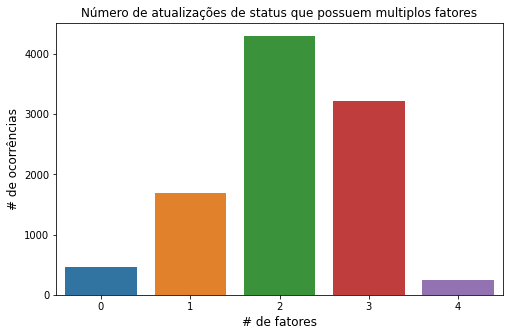

In [ ]:
#plot
import seaborn as sns

rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Número de atualizações de status que possuem multiplos fatores")
plt.ylabel('# de ocorrências', fontsize=12)
plt.xlabel('# de fatores', fontsize=12)

In [ ]:
from keras.utils.vis_utils import plot_model

#model plot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#plot
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.title("Número de palavras por sentença")
plt.ylabel('# de sentenças', fontsize=12)
plt.xlabel('# de palavras', fontsize=12)
plt.show()

In [ ]:
#wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

stopwords = set(STOPWORDS)
stopwords.update(["propname"])

text = " ".join(review for review in df['STATUS'])

wordcloud = WordCloud(background_color="black",
                      width=1600, height=800).generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")

In [ ]:
#metric plots
import matplotlib.pyplot as plt

#accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#auc
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])

plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])

plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#recall
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])

plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
#save model for later use
from keras.models import load_model
model.save("model.h5")

In [ ]:
#load model 
model = load_model('model.h5')

In [ ]:
#plot
traits_labels = df[["cEXT", "cNEU", "cAGR", "cCON", "cOPN"]]


fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

traits_labels.sum(axis=0).plot.bar()

In [ ]:
# predictions = model.predict(np.expand_dims(X_test[500], 0))

# print(tokenizer.sequences_to_texts([X_test[500]]))
# print(y_test[500])
# print(predictions)